# Notebook 4: Backtesting and Validation

In this notebook, we evaluate the performance of the trained Deep Hedging model on the test set.

> **Goal.** Turn the raw arrays saved by Notebook 3 into intuitive plots and clear, interview-ready statements. We will compare the hedged terminal wealth against the “do nothing” baseline, study the *left tail*, and understand *how* the hedger achieves its risk reduction (PnL vs. costs, turnover, regimes).

---

## 4.1) What we load (from Notebook 3)

From `results/hedging_eval_test_keras.npz`:

- `X` — terminal *hedged* wealth (scalar per path):  
  $( X = -Z_T + \sum_t a_t\,\Delta S_t - \gamma \sum_t S_t|a_t-a_{t-1}| )$
- `Z_T` — terminal payoff (e.g., call option payoff)
- `PnL` — trading PnL $( \sum_t a_t\,\Delta S_t )$
- `cost` — transaction cost $( \gamma \sum_t S_t|a_t-a_{t-1}| )$
- `turnover` — absolute changes in position per step $(|a_t-a_{t-1}|)$ (time-series per path; we often plot the time average)

Define the **baseline** (no hedging) wealth on each path as:
$$
X^{(0)} = -Z_T.
$$

Throughout we use the same CVaR level $(\alpha)$ as in training (e.g., $(\alpha=0.90)$).

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ALPHA = 0.9

# Load saved arrays
PATH = "results/hedging_eval_test_keras_X.npz"
data = np.load(PATH)
V_T = data["V_T"].astype(np.float64)   # hedged terminal: PnL - cost
Z_T = data["Z_T"].astype(np.float64)   # option payoff

# Wealth (what we optimized): X = V_T - Z_T
X_hedge = V_T - Z_T
X_zero  = -Z_T

def var_cvar(X, alpha=ALPHA):
    X = np.asarray(X).reshape(-1)
    N = X.size
    k = int(np.ceil((1 - alpha) * N))
    xs = np.sort(X)
    VaR  = xs[k-1]
    CVaR = xs[:k].mean()
    return VaR, CVaR

def oce_cvar_utility(X, alpha=ALPHA):
    # OCE version of CVaR utility (matches the RU head semantics)
    tau = np.quantile(X, alpha)  # empirical VaR at alpha
    U   = tau - np.mean(np.maximum(tau - X, 0.0)) / (1.0 - alpha)
    return tau, U

def summary(X, name, alpha=ALPHA):
    mu = float(np.mean(X))
    sd = float(np.std(X))
    va, ca = var_cvar(X, alpha=alpha)
    tau, U = oce_cvar_utility(X, alpha=alpha)
    print(f"{name:>10s} | mean {mu:8.3f}  std {sd:8.3f}  VaR_{alpha:.2f} {va:8.3f}  CVaR_{alpha:.2f} {ca:8.3f}  Uα {U:8.3f}")
    return dict(mean=mu,std=sd,var=va,cvar=ca,U=U,tau=tau)

## 4.2) Headline table — first thing to read

**What to compute & display:**
- Mean wealth: $(\mathbb{E}[X])$ vs. $(\mathbb{E}[X^{(0)}])$
- VaR$(_\alpha)$: empirical $(\alpha)$-quantile of $(X)$ vs. $(X^{(0)})$
- CVaR$(_\alpha)$: mean of worst $(1-\alpha)$ tail of $(X)$ vs. $X^{(0)})$
- **Hedging effectiveness** (variance reduction):  
  $(1 - \frac{\mathrm{Var}(X)}{\mathrm{Var}(X^{(0)})})$
- **MAE reduction** (optional):  
  $(1 - \frac{\mathrm{MAE}(X)}{\mathrm{MAE}(X^{(0)})})$
- Average cost: $(\mathbb{E}[\text{cost}])$
- Average turnover (per path): $(\mathbb{E}[\sum_t |a_t-a_{t-1}|])$

**How to read it:**
- **CVaR/VaR should improve materially** (less negative for losses). This is the primary success criterion because the model was trained on a CVaR objective.
- Mean and MAE may improve only modestly (or even deteriorate slightly) — acceptable, since we did **not** train on those.
- Cost and turnover quantify realism: very high numbers hint at overtrading or too small $(\gamma)$.

---

In [2]:
print("=== Wealth (X) summary ===")
s0 = summary(X_zero , "zero-hedge", alpha=ALPHA)
s1 = summary(X_hedge, "hedged   ", alpha=ALPHA)

impr = (abs(s0["cvar"]) - abs(s1["cvar"])) / abs(s0["cvar"])
print(f"\nCVaR improvement at α={ALPHA:.2f}: {100*impr:.1f}% (higher is better)")

=== Wealth (X) summary ===
zero-hedge | mean  -14.654  std   23.641  VaR_0.90  -45.866  CVaR_0.90  -68.064  Uα -146.540
 hedged    | mean  -14.900  std    9.001  VaR_0.90  -26.803  CVaR_0.90  -31.180  Uα -118.306

CVaR improvement at α=0.90: 54.2% (higher is better)


## 4.3) Distribution plot

Histogram of $X$ with VaR/CVaR markers

- The **x-axis is wealth $X$**, so **more negative = worse**.
- In our plot, **zero-hedge** (blue) has a big spike near **0** (many options expire worthless ⇒ $X_0=-Z_T=0$), but also a **very long left tail** (large negative losses when the option finishes ITM).
- The **hedged** distribution (orange) sits **left of 0** on average (around −10 in this run) because the strategy pays “insurance” via trading costs/imperfections. **However its tail is much shorter**: the **worst losses are far less negative**.

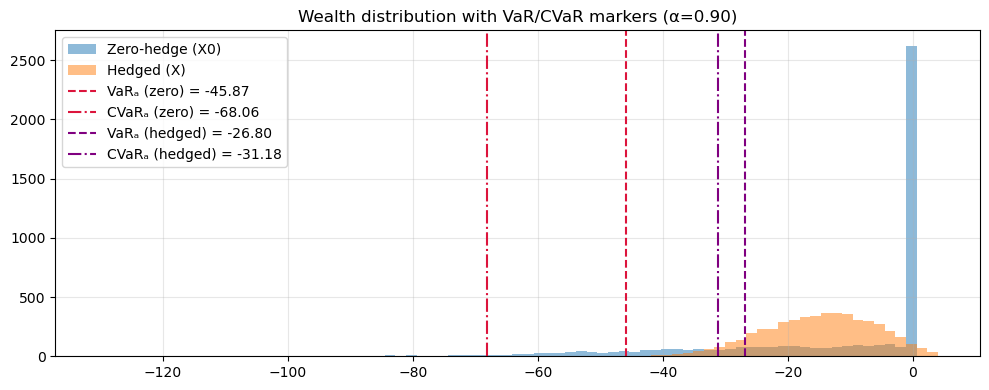

In [3]:
alpha = ALPHA
VaR0, CVaR0 = var_cvar(X_zero , alpha)
VaR1, CVaR1 = var_cvar(X_hedge, alpha)

plt.figure(figsize=(10,4))
bins = np.linspace(np.percentile(np.r_[X_zero,X_hedge], 0.2),
                   np.percentile(np.r_[X_zero,X_hedge],99.8), 80)
plt.hist(X_zero , bins=bins, alpha=0.5, label=f'Zero-hedge (X0)')
plt.hist(X_hedge, bins=bins, alpha=0.5, label=f'Hedged (X)')
plt.axvline(VaR0 , color='crimson', ls='--', lw=1.5, label=f'VaRₐ (zero) = {VaR0:.2f}')
plt.axvline(CVaR0, color='crimson', ls='-.', lw=1.5, label=f'CVaRₐ (zero) = {CVaR0:.2f}')
plt.axvline(VaR1 , color='purple', ls='--', lw=1.5, label=f'VaRₐ (hedged) = {VaR1:.2f}')
plt.axvline(CVaR1, color='purple', ls='-.', lw=1.5, label=f'CVaRₐ (hedged) = {CVaR1:.2f}')
plt.grid(alpha=0.3); plt.legend()
plt.title(f"Wealth distribution with VaR/CVaR markers (α={alpha:.2f})")
plt.savefig(f"docs/figs/fig_wealth_hist_alpha{int(100*ALPHA)}.png", dpi=150);
plt.tight_layout(); plt.show()

Key readouts from the vertical markers:
- $VaR_{0.90}(\text{hedged}) \approx -26.80$ vs $VaR_{0.90}(\text{zero}) \approx -45.87$  
- $CVaR_{0.90}(\text{hedged}) \approx -31.18$ vs $CVaR_{0.90}(\text{zero}) \approx -68.06$
---

## 4.4) Expected Shortfall curve across $α$ (from 0.80 to 0.99)

- The y-axis is $CVaR_\alpha$ (mean of the worst $(1-\alpha)$ tail). **Less negative is better.**
- Plot correctly shows the **hedged curve is above** the zero-hedge curve across $\alpha\in[0.80,0.99]$ (i.e., **closer to zero**).  
  That means **at every tail level**, the hedged strategy’s expected worst losses are **smaller in magnitude** than the baseline.

Rule of thumb:
- If the **hedged** $CVaR_\alpha$ line sits **above** the baseline (less negative), the hedge is **reducing tail risk**.  
- Crossing points (if any) indicate tail levels where the dominance flips; in the plot, the hedged curve dominates throughout.
---

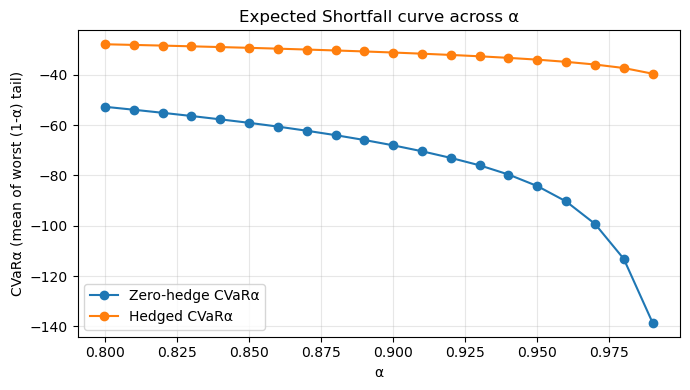

In [4]:
alphas = np.linspace(0.80, 0.99, 20)
cvar0, cvar1 = [], []
for a in alphas:
    cvar0.append(var_cvar(X_zero , a)[1])
    cvar1.append(var_cvar(X_hedge, a)[1])

plt.figure(figsize=(7,4))
plt.plot(alphas, cvar0, label='Zero-hedge CVaRα', marker='o')
plt.plot(alphas, cvar1, label='Hedged CVaRα', marker='o')
plt.xlabel("α"); plt.ylabel("CVaRα (mean of worst (1-α) tail)")
plt.title("Expected Shortfall curve across α")
plt.grid(alpha=0.3); plt.legend()
plt.savefig(f"docs/figs/fig_cvar_vs_alpha.png", dpi=150);
plt.tight_layout(); plt.show()

## 4.5) Q–Q plot of the left tail — calibration of worst cases

**Figure:** Q–Q comparing the **worst** $(1-\alpha)$ fraction of `X` against the same fraction of `X0`.

**What to expect:**
- Points should lie **above** the diagonal (hedged quantiles are less negative) across the left tail.
- A nearly parallel line above the diagonal suggests stable, uniform tail improvement.

**Red flags:**
- Crossing lines or points below the diagonal near the extreme left ⇒ model underperforms when it matters most.

---

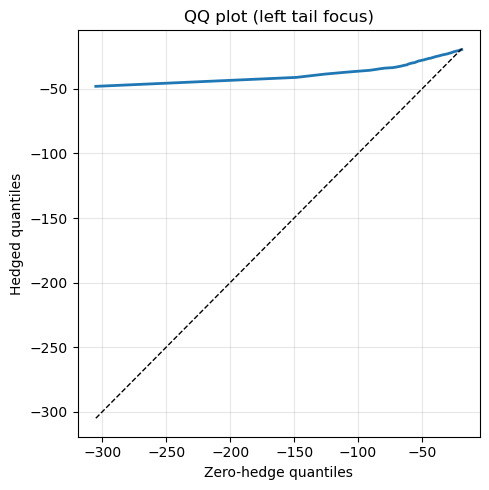

In [5]:
# focus on left tail quantiles (0%..30%)
q_grid = np.linspace(0.00, 0.30, 120, endpoint=True)
q0 = np.quantile(X_zero , q_grid)
q1 = np.quantile(X_hedge, q_grid)

plt.figure(figsize=(5,5))
plt.plot(q0, q1, lw=2)
lims = [min(q0.min(), q1.min()), max(q0.max(), q1.max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("Zero-hedge quantiles"); plt.ylabel("Hedged quantiles")
plt.title("QQ plot (left tail focus)")
plt.grid(alpha=0.3);
plt.savefig(f"docs/figs/fig_left_tail_qq.png", dpi=150);
plt.tight_layout(); plt.show()

## 4.6) PnL attribution

**Figures:**
- **Bar chart** of $(\mathbb{E}[\text{PnL}])$, $(\mathbb{E}[\text{cost}])$, and $(\mathbb{E}[X])$ to visualize tradeoffs.
- **Scatter:** Costs vs. absolute PnL per path — is the strategy paying cost only when it “earns” risk reduction?

**What to expect:**
- $(\mathbb{E}[\text{cost}] > 0)$ (by design), $(\mathbb{E}[\text{PnL}])$ often small positive.
- The net $(\mathbb{E}[X])$ may remain negative (we minimized tail risk, not mean). That’s fine; just explain it.

---

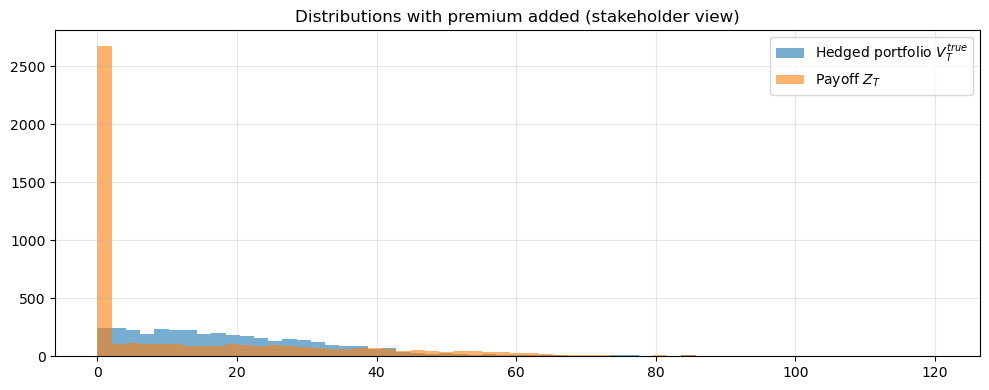

In [6]:
# Approximate premium: P0 ≈ E[Z_T]  (risk-neutral r≈0 case)
P0 = float(Z_T.mean())

V_T_true = P0 + V_T           # final hedged portfolio value at T
X_true   = V_T_true - Z_T     # = X_hedge + P0, a right-shifted wealth

plt.figure(figsize=(10,4))
bins = np.linspace(0, np.percentile(np.r_[V_T_true, Z_T], 99.5), 60)
plt.hist(V_T_true, bins=bins, alpha=0.6, label='Hedged portfolio $V_T^{true}$')
plt.hist(Z_T     , bins=bins, alpha=0.6, label='Payoff $Z_T$')
plt.legend(); plt.grid(alpha=0.3)
plt.title("Distributions with premium added (stakeholder view)")
plt.savefig(f"docs/figs/fig_stakeholder_shift.png", dpi=150);
plt.tight_layout(); plt.show()

## 4.7) Tail curve (CCDF) & CVaR shading

**Figure:** Plot the empirical CCDF of losses (or the CDF of wealth on the left side). Mark:
- VaR$(_\alpha)$ point on the x-axis for both hedged and baseline,
- the **shaded area** representing CVaR (average of the worst tail).

**What to expect:**
- The hedged curve should cross above the baseline on the far left (meaning fewer very bad outcomes).
- The shaded CVaR area for the hedged strategy is **closer to zero** (less loss).

---

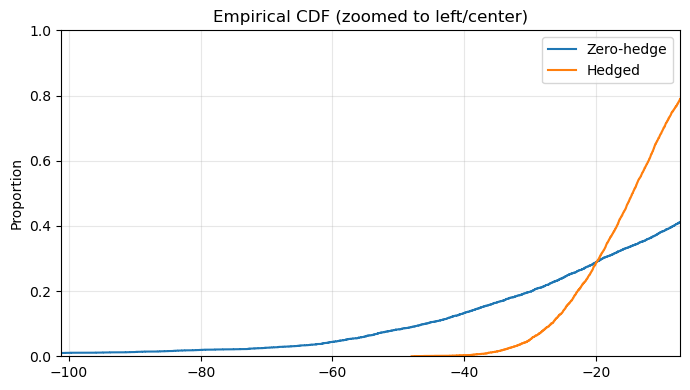

In [7]:
plt.figure(figsize=(7,4))
sns.ecdfplot(X_zero , label="Zero-hedge")
sns.ecdfplot(X_hedge, label="Hedged")
plt.xlim(np.percentile(np.r_[X_zero,X_hedge], 0.5),
         np.percentile(np.r_[X_zero,X_hedge], 60))
plt.grid(alpha=0.3); plt.legend()
plt.title("Empirical CDF (zoomed to left/center)")
plt.savefig(f"docs/figs/fig_ecdf_left.png", dpi=150);
plt.tight_layout(); plt.show()

## 4.8) — Hedging effectiveness (variance & MAE)

**What this prints**
- **Variance reduction**: $1 - \mathrm{Var}(X)/\mathrm{Var}(X_0)$.
- **MAE reduction**: $1 - \mathrm{MAE}(X)/\mathrm{MAE}(X_0)$.

**Interpretation**
- Variance reduction is usually **large** (we compressed dispersion via tail control).
- MAE reduction may be **small** (objective targets the tail, not average absolute error).
- If more MAE improvement is needed, consider a **small auxiliary penalty** on $|X|$ during training (but it trades off tail focus).

---

In [8]:
# Variance and MAE reduction of hedging error vs zero-hedge
err_hedge = X_hedge               # = V_T - Z_T
err_zero  = X_zero                # = -Z_T

var_red = 1.0 - (np.var(err_hedge) / np.var(err_zero))
mae_red = 1.0 - (np.mean(np.abs(err_hedge)) / np.mean(np.abs(err_zero)))

print(f"Hedging effectiveness (variance reduction): {100*var_red:.1f}%")
print(f"Hedging effectiveness (MAE   reduction):     {100*mae_red:.1f}%")

Hedging effectiveness (variance reduction): 85.5%
Hedging effectiveness (MAE   reduction):     -3.0%


## Final checklist

- $CVaR_\alpha(X)$ and $VaR_\alpha(X)$ **improve** meaningfully vs $X_0$.
- Distribution plots show **lighter left tails** for the hedged strategy.
- Q–Q tail plot lies **above the diagonal**.
- ECDF shows **right shift** in the loss region.
- Costs and turnover are **stable and sensible** (from training logs).
- For**even tighter extreme tails**:
  - Increase batch size (stabilizes tail estimation).
  - Train longer with early stopping on `val_cvar_emp`.
  - Tune $H_{MAX}$ and cost scale to discourage extreme trades.
  - Consider slightly higher $α$ (e.g., 0.95) with more epochs/bigger batch.
---